# Driving Scene Segmentation

Here I am going use Deeplab which is a state of the deep learning model for semantic segmentation. And I am going to use the MIT
sample driving scene vedio and I also learned it from MIT deep learning.

In [1]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.3.1


In the driving context, the aim is to obtain a semantic understanding of the front driving scene throught the camera input. This is important for driving safety and an essential requirement for all levels of autonomous driving. The first step is to build the model and load the pre-trained weights.Here I am goiong to use the model checkpoint trained on Cityscapes dataset.

In [2]:
class DeepLabModel(object):
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                #graph_def = tf.GraphDef.FromString(file_handle.read())
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [3]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Loading the model
There are two model checkpoints pre-trained on Cityscapes with MobileNetV2 and Xception65 . Here I will use MobileNetV2 for
faster inference.

In [4]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
#tf.io.gfile.MakeDirs(model_dir)
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Run on the sample image

running deeplab on the sample image...


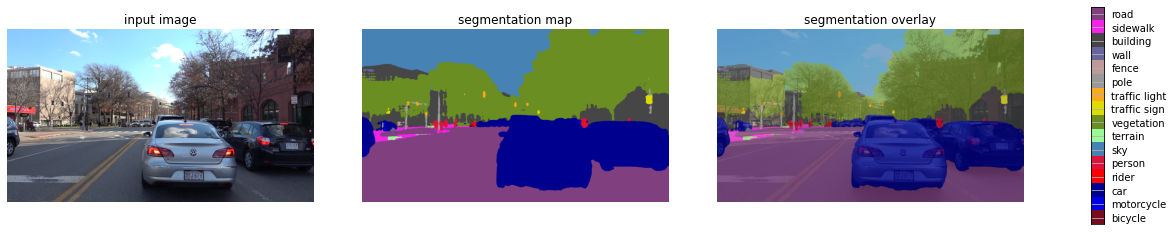

In [5]:
SAMPLE_IMAGE = './sample.png'
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE)

### Run on the sample video

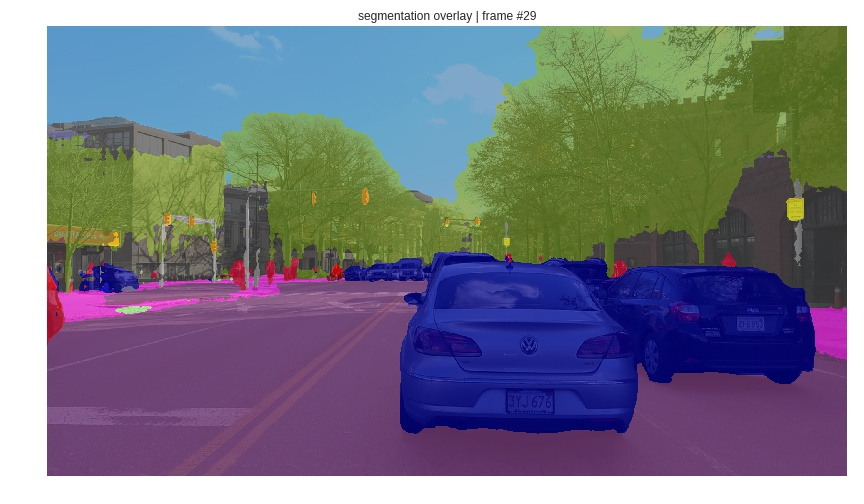

In [6]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame #%d'%index)
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)


SAMPLE_VIDEO = './sample.mp4'
video = cv.VideoCapture(SAMPLE_VIDEO)
#taking number of frames 30 for faster inference
num_frames = 30
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

### Evaluation

visualizing ground truth annotation on the sample image...


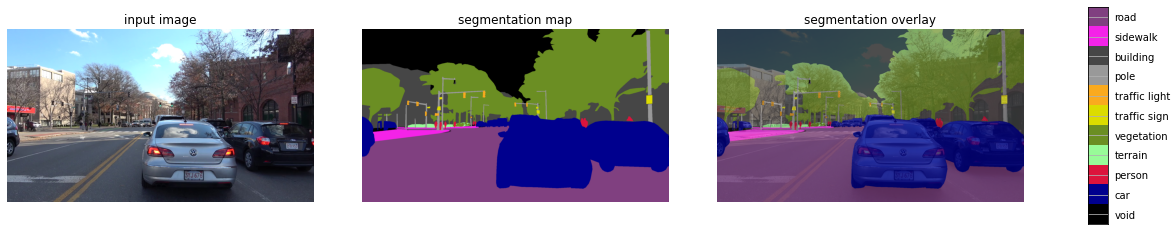

In [6]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()
    
    def fetch(self, index):
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = './sample_gt.tar.gz'
dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model.One is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [9]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703


### Evaluate on the sample video

In [9]:
print('evaluating on the sample video...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)

class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video...


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]

pixel accuracy: 0.8995
mean class IoU: 0.5276
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4104      0.5283  0.1594           0.4487          0.5508        0.8295     0.0474    0.3879  0.9582


### Leverage temporal information
Here we are using two frames instead of only one frame for making smoother preiction.

In [10]:
print('evaluating on the sample video with temporal smoothing...', flush=True)

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

acc = []
intersection = []
union = []
prev_seg_map_logits = 0

for i in tqdm(range(num_frames)):
    _, frame = video.read()
    original_im = Image.fromarray(frame[..., ::-1])
    
    # Get the logits instead of label prediction
    seg_map_logits = MODEL.run(original_im, OUTPUT_TENSOR_NAME='ResizeBilinear_3:0')
    
    # Add previous frame's logits and get the results
    seg_map = np.argmax(seg_map_logits + prev_seg_map_logits, -1)
    prev_seg_map_logits = seg_map_logits
    
    gt = dataset.fetch(i)
    _acc, _intersection, _union = evaluate_single(seg_map, gt)
    intersection.append(_intersection)
    union.append(_union)
    acc.append(_acc)
    
class_iou = np.round(np.sum(intersection, 0) / np.sum(union, 0), 4)
print('pixel accuracy: %.4f'%np.mean(acc))
print('mean class IoU: %.4f'%np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample video with temporal smoothing...


100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

pixel accuracy: 0.8998
mean class IoU: 0.5284
class IoU:
  road    sidewalk    building    pole    traffic light    traffic sign    vegetation    terrain    person     car
------  ----------  ----------  ------  ---------------  --------------  ------------  ---------  --------  ------
0.9554      0.4064      0.5285   0.158           0.4504           0.551        0.8297     0.0453    0.4008  0.9586
